# Introduction
##### In this dataset, each customer is classified as high or low credit risk according to the set of features and payment history. <br> 
##### If label is 1, the customer is in high credit risk. Dataset imbalance ratio is 20%.

**Data:** <br>
***payment_data.csv: customer’s card payment history.*** <br>
1. id: customer id
2. OVD_t1: number of times overdue type 1
3. OVD_t2: number of times overdue type 2
4. OVD_t3: number of times overdue type 3
5. OVD_sum: total overdue days
6. pay_normal: number of times normal payment
7. prod_code: credit product code
8. prod_limit: credit limit of product
9. update_date: account update date
10. new_balance: current balance of product
11. highest_balance: highest balance in history
12. report_date: date of recent payment

***customer_data.csv: customer’s demographic data*** <br>
The category attributes have been encoded. <br>
Category features are fea_1, fea_3, fea_5, fea_6, fea_7, fea_9.

**Tasks:** <br>
*   Explore data to give insights.
*   Build features from existing payment data.
*   Build model to predict high risk customer 
*   Model explanation and evaluation

# Import Packages

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from imblearn.over_sampling import RandomOverSampler;
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, precision_score,roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [ ]:
cust_df = pd.read_csv('/content/customer_data_ratio20.csv')
paymt_df = pd.read_csv('/content/payment_data_ratio20.csv')

# Data 

Time to get our hands dirty with some data cleaning.


## Payment Data

In [ ]:
paymt_df.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [ ]:
paymt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8250 non-null   int64  
 1   OVD_t1           8250 non-null   int64  
 2   OVD_t2           8250 non-null   int64  
 3   OVD_t3           8250 non-null   int64  
 4   OVD_sum          8250 non-null   int64  
 5   pay_normal       8250 non-null   int64  
 6   prod_code        8250 non-null   int64  
 7   prod_limit       2132 non-null   float64
 8   update_date      8224 non-null   object 
 9   new_balance      8250 non-null   float64
 10  highest_balance  7841 non-null   float64
 11  report_date      7136 non-null   object 
dtypes: float64(3), int64(7), object(2)
memory usage: 773.6+ KB


In [ ]:
# Percentage of missing values 
(paymt_df.isnull().sum()/paymt_df.isnull().count()*100).sort_values(ascending = False)

prod_limit         74.157576
report_date        13.503030
highest_balance     4.957576
update_date         0.315152
new_balance         0.000000
prod_code           0.000000
pay_normal          0.000000
OVD_sum             0.000000
OVD_t3              0.000000
OVD_t2              0.000000
OVD_t1              0.000000
id                  0.000000
dtype: float64

We can see that prod_limit has 74% missing values and wouldn't be of much significance during our statistical analysis.

## Customer Data

In [ ]:
cust_df.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1125 non-null   int64  
 1   id      1125 non-null   int64  
 2   fea_1   1125 non-null   int64  
 3   fea_2   976 non-null    float64
 4   fea_3   1125 non-null   int64  
 5   fea_4   1125 non-null   float64
 6   fea_5   1125 non-null   int64  
 7   fea_6   1125 non-null   int64  
 8   fea_7   1125 non-null   int64  
 9   fea_8   1125 non-null   int64  
 10  fea_9   1125 non-null   int64  
 11  fea_10  1125 non-null   int64  
 12  fea_11  1125 non-null   float64
dtypes: float64(3), int64(10)
memory usage: 114.4 KB


We can see that fea_2 has some null values that needs to be handled before we proceed with EDA/Model Building.


In [ ]:
# Percentage of missing values 
(cust_df.isnull().sum()/cust_df.isnull().count()*100).sort_values(ascending = False)

fea_2     13.244444
fea_11     0.000000
fea_10     0.000000
fea_9      0.000000
fea_8      0.000000
fea_7      0.000000
fea_6      0.000000
fea_5      0.000000
fea_4      0.000000
fea_3      0.000000
fea_1      0.000000
id         0.000000
label      0.000000
dtype: float64

In [ ]:
cust_df.describe()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781


In [ ]:
# Lets fill up the missing values using the average value of fea_2
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
cust_df['fea_2'] = imputer.fit_transform(cust_df['fea_2'].values.reshape(-1, 1))

In [ ]:
# check for duplicate records
cust_df[cust_df.duplicated()]

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11


In [ ]:
temp_df = pay_cus.groupby(['label'])['id'].nunique().reset_index()
temp_df = temp_df.sort_values(by=['id'],ascending=False)

layout = dict(
    title_text = "<b> Count of Customers By Label </b>",
    xaxis_title="ID",
    yaxis_title="Count",
    title_x = 0.5)

fig = px.bar(x=temp_df['label'],y= temp_df['id'],
             color = temp_df['id'],
             color_continuous_scale=px.colors.sequential.Sunset)

fig.update_layout(layout, template = 'plotly_white')   
fig.show()

As we can see, our model data is highly imbalanced and handling this should give us a good model for predicting high risk customers.

# Feature Engineering for our Model using given customer attributes

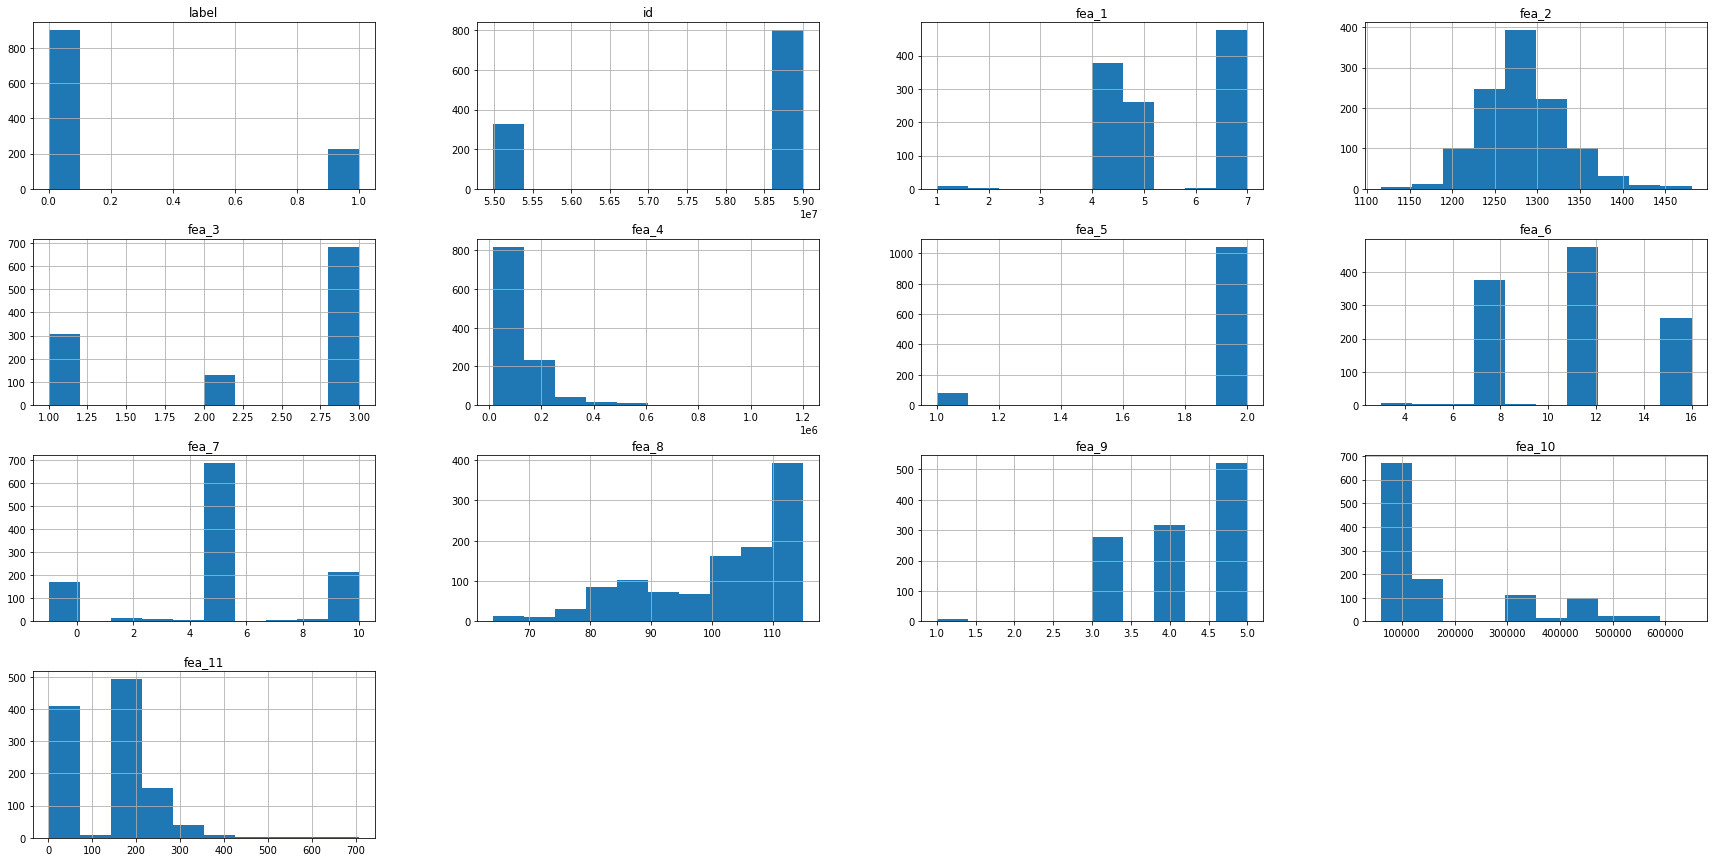

In [ ]:
# Distribution of our feature variables
cust_df.hist(figsize=(30,15));

Firstly, it can be noticed that our data doesn't strictly follow a normal distribution curve and considering the variance in scales,<b> it would be best to normalize our data.</b> 

We can observe that we have some categorical features (Ex. fea_7, fea_3 etc.) as well as some continuous variables like (fea_2, fea_4, fea_8 etc.). 

Some of our continuous variables like fea_4 needs to be tranformed inorder to follow a bell curve and make them as "normally distributed" as possible which would make the results of the models built using these features more valid.

We can accomplish the same using the Log transformation as shown below.

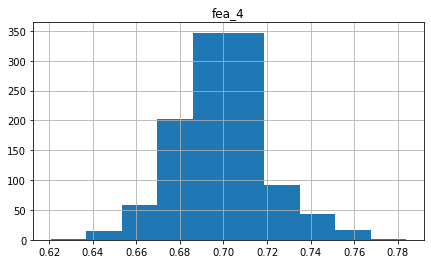

In [ ]:
cust_df['fea_4'] = np.log10(cust_df['fea_4'])
cust_df.hist(['fea_4'],figsize=(7,4));

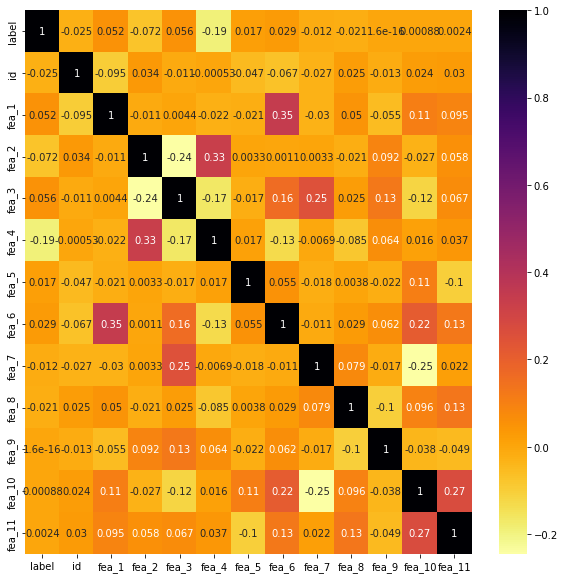

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(cust_df.corr(), cmap = 'inferno_r',annot= True);

Although there are no positive correlations, we can notice some negative correlation between features: 

*   fea_10 and fea_7
*   fea_3 and fea_2
*   label and fea_4

Let's try to visualize the numerical features that we have identified.

In [ ]:
fig = px.scatter_3d(cust_df, x='fea_2', y='fea_4', z='fea_8',color='label')
fig.show()

# Train-Test Split

Let's preprocess our data and split it into training and test sets for model building and evaluation

In [ ]:
cust_df.columns

Index(['label', 'id', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6',
       'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11'],
      dtype='object')

We are not taking the ID column into consideration because it wouldn't help our model much in terms of generalization. 

In [ ]:
features = cust_df.loc[:,cust_df.columns[2:]]  
y = cust_df['label'].values

In [ ]:
# normalizing our input feature data
X = MinMaxScaler().fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size = 0.25)

# Defining our metric(s)

Before we proceed with model build, it's best practice to define our metric that would potentially help us in evaluating the different models we build.

<b>This takes the task of understanding the problem statement and the objective of the model. <br>
In our case, as we're trying to classify high risk customers, it's best to choose "Recall" as our metric. </b>

To put this into context and simple words, if the precision of our model is at say, 70%, then it means that our model is only correct 70% of the time when it claims a customer is a high risk customer. 

If the recall of the model is at 85%, then it indicated that our model detects and catches 85% of the high risk customers from the dataset. 

**Therefore, with having recall as our metric, we should be moving in the right direction.**

Other metrics like F1 (Harmonic mean of precision and recall) is not advised because harmonic mean gives more weight to low values and a high F1 is obtained only if <b> both </b> precision and recall are high. 

***Note: It is to be kept in mind that a higher recall would have a causal effect on precision causing it to be lower due to the precision-recall trade off.***

# Model Building

Let's train a naive classification model to get started with

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       226
           1       0.00      0.00      0.00        56

    accuracy                           0.80       282
   macro avg       0.40      0.50      0.44       282
weighted avg       0.64      0.80      0.71       282

Precision score is 0.0 and Recall core is 0.0


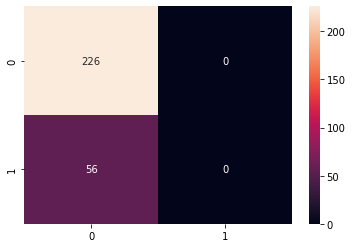

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# Confusion matrix and classification report
print(classification_report(y_test, y_pred, zero_division=0))
cf_matrix = confusion_matrix(y_test, y_pred)
heatmap = sns.heatmap(cf_matrix,annot=True, fmt='d', color='blue')
print("Precision score is {} and Recall core is {}".format(precision_score(y_test,y_pred,zero_division=0), recall_score(y_test,y_pred,zero_division=0)))

As we can see, we are off to a rough start but this is expected given the imbalance in our data set.  Basically, our model classifies everything as low risk inorder to achieve a high accuracy.

Let's use Isolation Forest algoritm to mask out the anomalies present in the dataset.
I'm choosing this algorithm for its robustness as it involves chopping up the dataset into pieces to isolate them based on a random feature and threshold value. Anomalies are identifies as those instances that are usually far from the other nodes. 

Other alternatives to accomplish the same are 
*  PCA
*  One Class SVM
*  Local outlier factor.



In [ ]:
iso = IsolationForest(contamination=0.01,random_state=42)
y_pred = iso.fit_predict(X_train,y_train)
mask = y_pred != -1
X_train,y_train = X_train[mask,:],y_train[mask]

## Building our baseline model

In [ ]:
models = []
results = []
names = []
scoring = 'recall'  #the metric we decided upon
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))

for name, model in models:
        kfold = KFold(n_splits=7, random_state=42,shuffle = True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        opt = "%s has an average recall of : %f with Standard Deviation: %f" % (name, cv_results.mean(), cv_results.std())
        print(opt)

KNN has an average recall of : 0.072395 with Standard Deviation: 0.048067
CART has an average recall of : 0.314707 with Standard Deviation: 0.091439
NB has an average recall of : 0.012266 with Standard Deviation: 0.020534
RF has an average recall of : 0.084106 with Standard Deviation: 0.036521
XGB has an average recall of : 0.055084 with Standard Deviation: 0.045275


We still have a low recall which needs to be increased for achieving a better model. 

A smart approach would be to gather more data to balance the training set. 
In case, thats not possible, we could trying methods like 
*   Brute force hyperparameter tuning 
*   Over Sampling and/or Under Sampling (We'll be choosing OverSampling for our solution)

**In my personal opinion, I would go for the second approach of Over sampling the data inorder to build a better model.**

However, we can explore both the approaches here.



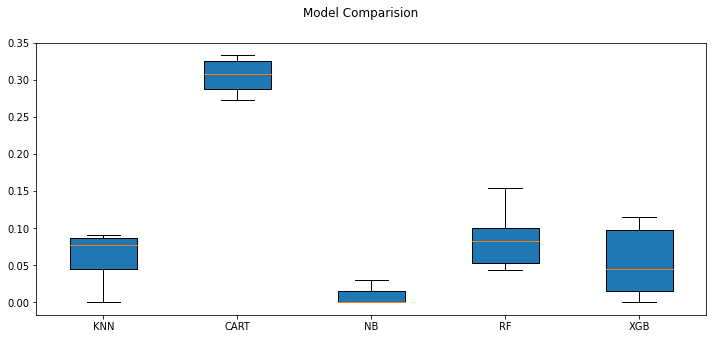

In [ ]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Model Comparision')
ax = fig.add_subplot(111)
plt.boxplot(results, patch_artist=True,showfliers=False)
ax.set_xticklabels(names)
plt.show()

As its observed that CART (Decision Tree) classifier has a relatively higher recall, we can start tuning the hyper parameters for the same. 

When it comes to tuning for increasing the recall, we have the following options:
*   Tune the hyperparameters using GridSearch and tune the decision threshold for a better recall

### Naive CART (Decision Tree)

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       226
           1       0.26      0.30      0.28        56

    accuracy                           0.69       282
   macro avg       0.54      0.55      0.54       282
weighted avg       0.71      0.69      0.70       282

Precision score is 0.26153846153846155 and Recall core is 0.30357142857142855


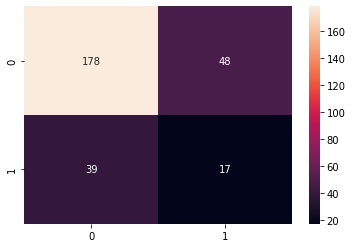

In [ ]:
dt = DecisionTreeClassifier( max_features=11, min_samples_split= 6, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
cf_matrix = confusion_matrix(y_test, y_pred)
heatmap = sns.heatmap(cf_matrix,annot=True, fmt='d', color='blue')
print("Precision score is {} and Recall core is {}".format(precision_score(y_test,y_pred,zero_division=0), recall_score(y_test,y_pred,zero_division=0)))

A naive decision tree gives a recall of 30

### Tuning using GridSearch for CART - Optimizing Recall

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'min_samples_split': [2,3,5,6], 
    'max_depth': [10,15,18,20,30],
    'max_features': [4,10, 11]
}

def grid_search_function(refit_score='recall_score'):

    skf = StratifiedKFold(n_splits=7)
    grid_search = GridSearchCV(dt, param_grid, scoring=make_scorer(recall_score), refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)
    predict_score= grid_search.predict_proba(X_test)[:,1]

    print('Best params {}'.format(refit_score))
    print(grid_search.best_params_)
    print(grid_search.best_score_)

    print('\nConfusion matrix of CART optimized for {}:'.format(refit_score))
    print(classification_report(y_test, y_pred, zero_division=0))
    cf_matrix = confusion_matrix(y_test, y_pred)
    heatmap = sns.heatmap(cf_matrix,annot=True, fmt='d', color='blue')
    print("Precision score is {} and Recall score is {}".format(precision_score(y_test,y_pred,zero_division=0), recall_score(y_test,y_pred,zero_division=0)))
    return predict_score, grid_search



Best params recall_score
{'max_depth': 20, 'max_features': 10, 'min_samples_split': 2}
0.32142857142857145

Confusion matrix of CART optimized for recall_score:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       226
           1       0.29      0.36      0.32        56

    accuracy                           0.70       282
   macro avg       0.56      0.57      0.56       282
weighted avg       0.72      0.70      0.71       282

Precision score is 0.2857142857142857 and Recall score is 0.35714285714285715


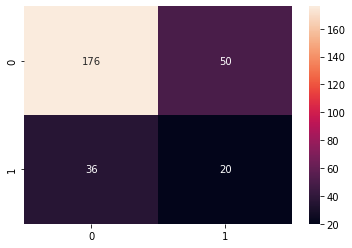

In [ ]:
predict_score, grid_search_clf = grid_search_function(refit_score='recall_score')

Area Under Curve is 0.56795195954488


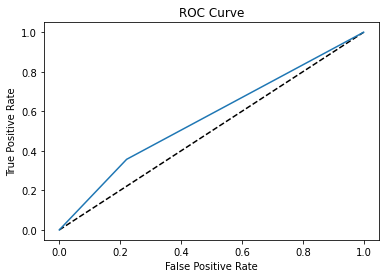

In [ ]:
fpr, tpr, _ =  roc_curve(y_test, predict_score)
print("Area Under Curve is {}".format(roc_auc_score(y_test, predict_score)))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The gridsearch optimized to recall score has helped our model to improve its recall to 36 but this is still not a "production worthy" model that solves our problem.

#### Further tuning using the decision threshold for recall

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
predict_score = dt.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, predict_score)

In [ ]:
# A step wise function with the given threshold (t)
def step_wise(predict_score, t):  
    return [1 if y >= t else 0 for y in predict_score]

In [ ]:
def precision_recall_threshold(precision, recall, thresholds, t=0.5):
   
    y_pred_cls = step_wise(predict_score, t)
    print(classification_report(y_test, y_pred_cls, zero_division=0))
    cf_matrix = confusion_matrix(y_test, y_pred_cls)
    heatmap = sns.heatmap(cf_matrix,annot=True, fmt='d', color='blue')
    print("Precision score is {} and Recall core is {}".format(precision_score(y_test,y_pred,zero_division=0), recall_score(y_test,y_pred,zero_division=0)))
    
    plt.figure(figsize=(6,7))
    plt.title("Precision and Recall curve -  ^ = current threshold")
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='r')
    plt.ylim([0, 1.01]);
    plt.xlim([0, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(recall[close_default_clf], precision[close_default_clf], '^', c='k',
            markersize=15)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       226
           1       0.27      0.36      0.31        56

    accuracy                           0.68       282
   macro avg       0.55      0.56      0.55       282
weighted avg       0.72      0.68      0.70       282

Precision score is 0.273972602739726 and Recall core is 0.35714285714285715


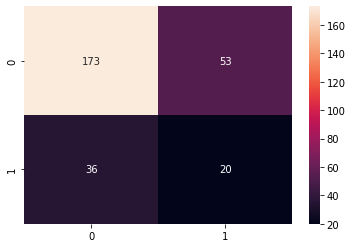

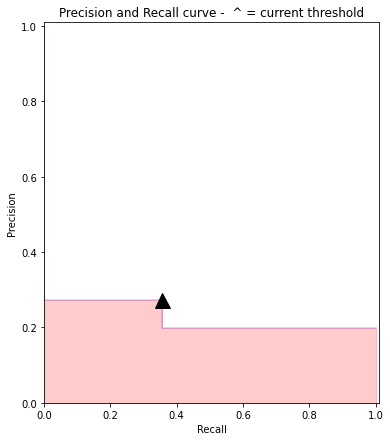

In [ ]:
precision_recall_threshold(precision, recall, thresholds, 0.7)

Area Under Curve is 0.561314791403287


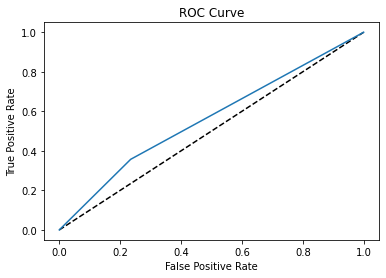

In [ ]:
fpr, tpr, _ =  roc_curve(y_test, predict_score)
print("Area Under Curve is {}".format(roc_auc_score(y_test, predict_score)))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Well, the decision function didn't help much in our case. 
Let's try our next approach.

## Best Solution - After handling the imbalanced data

A smart way to overcome challenges from imbalanced data is to generate new samples in the classes which are under-represented.

The different available methods are:


In [ ]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, shuffle=True, stratify=y_resampled, test_size = 0.25)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
results = []
for name, model in models:
        kfold = KFold(n_splits=7, random_state=42,shuffle = True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        opt = "%s has an average recall of : %f with Standard Deviation: %f" % (name, cv_results.mean(), cv_results.std())
        print(opt)

KNN has an average recall of : 0.765406 with Standard Deviation: 0.027026
CART has an average recall of : 0.942317 with Standard Deviation: 0.011111
NB has an average recall of : 0.604442 with Standard Deviation: 0.059413
RF has an average recall of : 0.940941 with Standard Deviation: 0.018692
XGB has an average recall of : 0.743155 with Standard Deviation: 0.025638


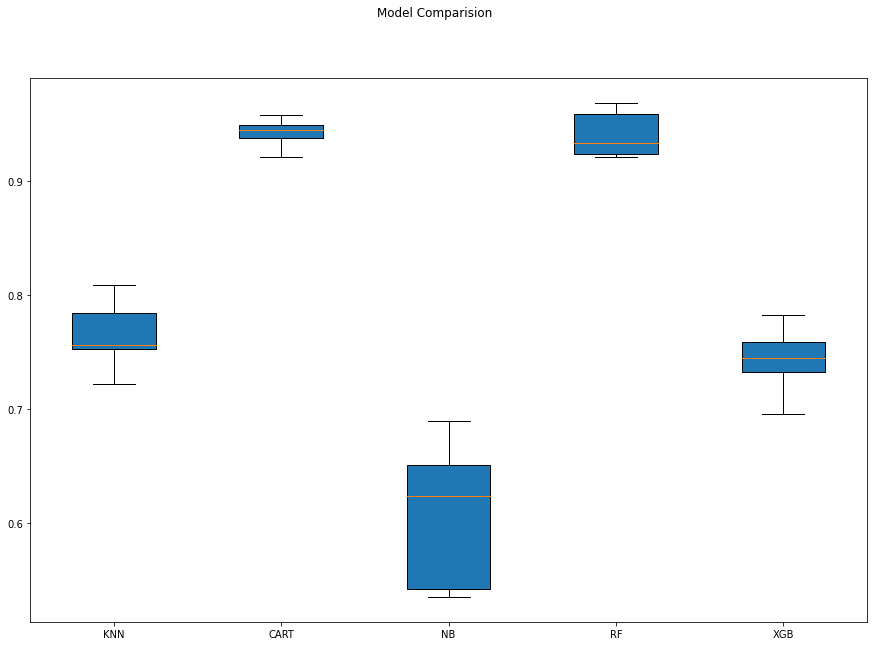

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Model Comparision')
ax = fig.add_subplot(111)
plt.boxplot(results, patch_artist=True,showfliers=False)
ax.set_xticklabels(names)
plt.show()

Best params recall_score
{'max_depth': 18, 'max_features': 11, 'min_samples_split': 2}
0.9511383161512029

Confusion matrix of CART optimized for recall_score:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       225
           1       0.77      0.99      0.87       225

    accuracy                           0.85       450
   macro avg       0.88      0.85      0.85       450
weighted avg       0.88      0.85      0.85       450

Precision score is 0.7743055555555556 and Recall score is 0.9911111111111112


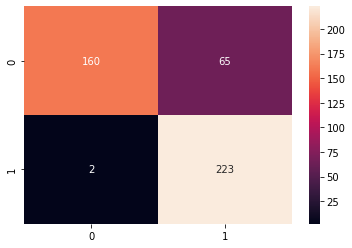

In [ ]:
predict_score, grid_search_clf = grid_search_function(refit_score='recall_score')

Area Under Curve is 0.8545382716049382


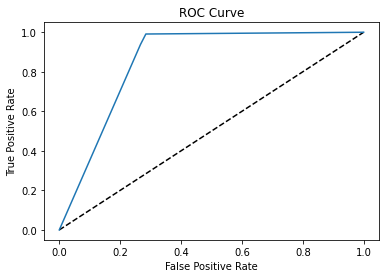

In [ ]:
fpr, tpr, _ =  roc_curve(y_test, predict_score)
print("Area Under Curve is {}".format(roc_auc_score(y_test, predict_score)))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Conclusion

We have a better model with recall of about 0.85 and Area under curve of 1. 
This model should weed out the higher risk customers in an efficient but sometimes at the cost of categorizing some low risk customers also as high risk customers. 
This could, however, be mitigated by adding more training data and further tuning of the hyperparameters with a wide parameter search space. 

# Exploratory Data Analysis Of Payment Data

In [ ]:
pay_cus = pd.merge(cust_df,paymt_df, on='id', how ='inner')

In [ ]:
temp_df = pay_cus.groupby(['label'])['highest_balance'].mean().reset_index()
temp_df = temp_df.sort_values(by=['highest_balance'],ascending=False)

layout = dict(
    title_text = "<b> Average Highest Balance By Label </b>",
    xaxis_title="Label",
    yaxis_title="Mean Highest Balance",
    title_x = 0.5)

fig = px.bar(x=temp_df['label'],y= temp_df['highest_balance'],
             color = temp_df['highest_balance'],
             color_continuous_scale=px.colors.sequential.RdBu)

fig.update_layout(layout, template = 'plotly_dark')   
fig.show()

The plot shown above reflects that high risk customer has larger all time high account balance which could be due to some accounts with large amount of funds with its sources being unclear. 
For example, 
* non­resident customers
* high net worth individuals 
* trusts, charities, NGOs and organizations receiving donations etc

The same hypothesis can also be strengthened using a similar plot for current account balance. 

In [ ]:
temp_df = pay_cus.groupby(['label'])['new_balance'].mean().reset_index()
temp_df = temp_df.sort_values(by=['new_balance'],ascending=False)

layout = dict(
    title_text = "<b> Average Current Balance By Label </b>",
    xaxis_title="Label",
    yaxis_title="Mean Current Balance",
    title_x = 0.5)

fig = px.bar(x=temp_df['label'],y= temp_df['new_balance'],
             color = temp_df['new_balance'],
             color_continuous_scale=px.colors.sequential.RdBu)

fig.update_layout(layout, template = 'plotly_dark')

In [ ]:
layout = dict(
    title_text = "<b> Normal Pay Distribution by Label </b>",
    xaxis_title="Number of Normal Payment",
    yaxis_title="Frequency",
    title_x = 0.5)

fig = px.line(pay_cus,
              x=pay_cus[pay_cus['label']==0]['pay_normal'].value_counts().sort_index().index,
              y=pay_cus[pay_cus['label']==0]['pay_normal'].value_counts().sort_index().values
              )

fig.add_trace(go.Scatter(x=pay_cus[pay_cus['label']==1]['pay_normal'].value_counts().sort_index().index,
                         y=pay_cus[pay_cus['label']==1]['pay_normal'].value_counts().sort_index().values,
                         name="High Risk",
                         line=dict(color="red")))

fig.update_layout(layout, template = 'plotly_dark')
fig.show()

We can observe from the plot above that both High Risk and Low Risk Customers have a mostly similar trend in making normal payments although there are definitely some uncertainities , especially towards the end that causes more overdue days for high risk customers.

The difference in amplitude can be explain with the lack of enough number of High risk data points.

In [ ]:
temp_df = pay_cus.groupby(['label'])['OVD_sum'].mean().reset_index()
temp_df = temp_df.sort_values(by=['OVD_sum'],ascending=False)

layout = dict(
    title_text = "<b> Average Total OverDue Days Sum By Label </b>",
    xaxis_title="Label",
    yaxis_title="Average Total OverDue Days Sum",
    title_x = 0.5)

fig = px.bar(x=temp_df['label'],y= temp_df['OVD_sum'],
             color = temp_df['OVD_sum'],
             color_continuous_scale=px.colors.sequential.RdBu)

fig.update_layout(layout, template = 'plotly_dark')

The above mentioned plot confirms that high risk customer have more overdue days on average

In [ ]:
temp_df = pay_cus.groupby(['label','prod_code'])['new_balance'].mean().reset_index();
temp_df = temp_df.sort_values(by=['new_balance'],ascending=False)

fig = px.bar(temp_df, x="prod_code", y="new_balance",color='label',barmode='stack')

fig.update_layout(barmode ='group',
                  title_x = 0.5,
                  title_text = "<b> Avergage Current balance </b>",
                  xaxis_title="Product Code",
                  xaxis=dict(tickmode='linear'),
                  yaxis_title="Population and Engagement Index",
                  template="plotly_white")
fig.show()

From the plot above, we can observe that product 2,3 contain the highest avergage account balance.

***That brings us to the end of my first notebook for my technical assessment submission.***